# TBrain Esunbank Suspicious Activity Report

## Import Package

In [2]:
import os
import time
import random
import numpy as np
import pandas as pd

In [3]:
import tensorflow as tf
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.6.0


In [4]:
SEED = 5397
random.seed(SEED)
np.random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)

In [5]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print("Device:", tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
except ValueError:
    print("Not connected to a TPU runtime. Using CPU/GPU strategy")
    device_name = tf.test.gpu_device_name()
    if device_name != '/device:GPU:0':
        raise SystemError('GPU device not found')
    print('Found GPU at: {}'.format(device_name))
    # Show GPU information
    gpu_info = !nvidia-smi
    gpu_info = '\n'.join(gpu_info)
    if gpu_info.find('failed') >= 0:
        print('Not connected to a GPU')
    else:
        print(gpu_info)
    strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0"])

Not connected to a TPU runtime. Using CPU/GPU strategy
Found GPU at: /device:GPU:0
Wed Nov 23 18:28:10 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 512.59       Driver Version: 512.59       CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
|  0%   37C    P2    25W / 160W |    508MiB /  6144MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
     

## Helper Functions

Before we write the code for adjusting the models, lets define a few helper functions.

In [6]:
def cdtx_from_date_to_byymm(date, byymm_list):
    byymm = None # [0, 30, 61, 91, 122, 153, 183, 214, 244, 275, 306, 334, 365]
    for i in range(len(byymm_list)):
        if(byymm_list[i] == byymm_list[len(byymm_list)-1]):
            if(byymm_list[i] <= date):
                byymm = byymm_list[i]
        else:
            if(byymm_list[i] <= date < byymm_list[i+1]):
                byymm = byymm_list[i]
    return byymm

In [7]:
# Processing of data provided by the organizer 
def alert_data_merge(alert, answer, custinfo):
    data = pd.merge(answer, alert, on=['alert_key'], how='left')
    data = pd.merge(data, custinfo, on='alert_key', how='left')
    return data

## Const & Inputs

Here are all of the parameters to change for the run.

In [8]:
# Top level data directory. Here we assume the format of the directory conforms to the ImageFolder structure
path = "."

# look_back
look_back = 14

# Numerical
numerical = [
    'risk_rank', 'total_asset', 'AGE', 
    'trade_amount_usd', 'trans_counts'
]

# Categorical
categorical = [
    'occupation_code', 
    'trans_no'
]

# 2020 為閏年 2 月有 29 天，這裡 2 月只有 28 天所以是 2021 年
byymm_mapping = {
    '0': '2020/03', '30': '2020/04', '61': '2020/05', '91': '2020/06', '122': '2020/07', 
    '153': '2020/08', '183': '2020/09', '214': '2020/10', '244': '2020/11', '275': '2020/12',
    '306': '2021/01', '334': '2021/02', '365': '2021/03'
}

## Data Preprocessing

Processing of data provided by the organizer.

### custinfo

In [9]:
custinfo = pd.read_csv(os.path.join(path, 'data/public_train_x_custinfo_full_hashed.csv'))
print('custinfo.cust_id.size:', len(custinfo.groupby('cust_id').size()))
custinfo.head(3)

custinfo.cust_id.size: 7708


,alert_key,cust_id,risk_rank,occupation_code,total_asset,AGE
0,352249,82595ac69158ae08d34156784bdec0d9e2ca5b242b6d2a...,1,19.0,1465816.0,7
1,352253,b212d14cb35676926682b2cf849e295d948888f556c07e...,1,2.0,98177.0,2
2,352254,e5b0002791c7852644a2730abeaa893cdf14a072ef7812...,1,19.0,2052922.0,7


In [10]:
custinfo.describe()

,alert_key,risk_rank,occupation_code,total_asset,AGE
count,25751.000000,25751.000000,25635.000000,2.575100e+04,25751.000000
mean,265685.626927,1.610578,14.251063,7.137427e+05,3.633024
std,58623.840868,0.906222,4.690025,2.435461e+06,1.309948
min,171142.000000,0.000000,0.000000,0.000000e+00,0.000000
25%,212536.000000,1.000000,12.000000,7.508000e+03,3.000000
50%,266346.000000,1.000000,15.000000,1.288800e+05,3.000000
75%,316658.500000,3.000000,19.000000,5.972315e+05,4.000000
max,365073.000000,3.000000,20.000000,7.386321e+07,10.000000


Handle Missing Values

In [11]:
custinfo['occupation_code'] = custinfo['occupation_code'].fillna(21)

### alert and flag
Combine x and y

In [12]:
train_alert = pd.read_csv(os.path.join(path, 'data/train_x_alert_date.csv'))
train_y_answer = pd.read_csv(os.path.join(path, 'data/train_y_answer.csv')).drop(['set_name'], axis=1)
public_alert = pd.read_csv(os.path.join(path, 'data/public_x_alert_date.csv'))
public_y_answer = pd.DataFrame({'alert_key': public_alert['alert_key'], 'sar_flag': [np.nan]*len(public_alert)})

In [13]:
# TODO: concat with private alert
full_alert  = pd.concat([train_alert, public_alert], axis=0, ignore_index=True)

Use oversampling to handle imbalanced data

In [14]:
train_y_answer_groupby_y = train_y_answer.groupby(['sar_flag']).size().reset_index(name='counts')
train_y_answer_groupby_y

,sar_flag,counts
0,0,23672
1,1,234


In [15]:
class_ratio = train_y_answer_groupby_y['counts'].max()//train_y_answer_groupby_y['counts'].min()
train_y_answer_balanced = pd.concat([train_y_answer[train_y_answer['sar_flag'].eq(1)]]*class_ratio, axis=0, ignore_index=True)
train_y_answer_balanced = pd.concat([train_y_answer_balanced, train_y_answer[train_y_answer['sar_flag'].eq(0)]], axis=0, ignore_index=True)
train_y_answer_balanced.groupby(['sar_flag']).size().reset_index(name='counts')

,sar_flag,counts
0,0,23672
1,1,23634


In [16]:
train = alert_data_merge(train_y_answer_balanced, train_alert, custinfo)
public = alert_data_merge(public_y_answer, public_alert, custinfo)
train.head(5)

,alert_key,date,set_name,sar_flag,cust_id,risk_rank,occupation_code,total_asset,AGE
0,171189,0,train,0,972ee157e63316e8a50dd489bc93730a3ee8a8959d5c6b...,1,17.0,375576.0,4
1,171202,0,train,0,a10ab33f90926fb18d7bb5e78034d7f04a1fbed95b7951...,3,12.0,2717416.0,2
2,171599,0,train,0,3433ecc068ed1c9e2f5037cab5d42d7b901e9bd624c1fb...,1,12.0,326517.0,4
3,171737,0,train,0,a0861608615a9365d90f4ba0a813c0ea0471987f925c8b...,3,14.0,1014759.0,4
4,171142,0,train,0,a39fea9aec90969fe66a2b2b4d1b86368a2d38e8b8d4bf...,3,12.0,241719.0,3


### custinfo with date
原始的 custinfo 沒有時間戳記，難以與其他資料整合，這邊與 alert 資料合併取得時間戳記

In [17]:
custinfo_with_date = custinfo.copy()
custinfo_with_date = pd.merge(custinfo_with_date, full_alert, on='alert_key', how='left').drop(['set_name'], axis=1)
custinfo_with_date.describe()

,alert_key,risk_rank,occupation_code,total_asset,AGE,date
count,25751.000000,25751.000000,25751.000000,2.575100e+04,25751.000000,25751.000000
mean,265685.626927,1.610578,14.281465,7.137427e+05,3.633024,198.164032
std,58623.840868,0.906222,4.701225,2.435461e+06,1.309948,118.263229
min,171142.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,212536.000000,1.000000,12.000000,7.508000e+03,3.000000,92.000000
50%,266346.000000,1.000000,15.000000,1.288800e+05,3.000000,210.000000
75%,316658.500000,3.000000,19.000000,5.972315e+05,4.000000,295.000000
max,365073.000000,3.000000,21.000000,7.386321e+07,10.000000,393.000000


### convert to daily data

時間序列模型可以基於警報發生當下及過去的資料來判斷警報嚴重程度，其中對於過去資料的回推單位在這裡設定為 1 日，為此必須先克服 2 個問題

1. 資料在 1 日內可能有複數筆，例如：警報在同 1 日可能發生複數次、匯款或信用卡交易在同 1 日可能發生複數次

2. 資料的前後間隔可能超過 1 日，例如：客戶在 2020.11.17 匯款後，下次匯款可能在 2 日後的 2020.11.19 發生

#### alert

警報是最關鍵的屬性，因為它代表 y 的頻率，若警報在單 1 日內觸發多次的頻率過高，就不能將回推單位設定為 1 天

同 1 個客戶在單日觸發 2 次警報的情況在 training set 為 0.9245% 應該可以先忽略不理會

In [18]:
single_day_multi_alerts = train.groupby(['cust_id', 'date']).size().reset_index(name='counts')
single_day_multi_alerts = single_day_multi_alerts[single_day_multi_alerts['counts']>1]
print('train:', len(train))
print('single_day_multi_alerts:', len(single_day_multi_alerts))
print(F'{len(single_day_multi_alerts)} / {len(train)} = {round(len(single_day_multi_alerts)/len(train)*100, 4)}%')

train: 47306
single_day_multi_alerts: 454
454 / 47306 = 0.9597%


在 public set 觸發 2 次警報的比例為 4.065% 較 training set 高，但也還不是很嚴重

In [19]:
single_day_multi_alerts_public = public.groupby(['cust_id', 'date']).size().reset_index(name='counts')
single_day_multi_alerts_public = single_day_multi_alerts_public[single_day_multi_alerts_public['counts']>1]
print(F'{len(single_day_multi_alerts_public)} / {len(public)} = {round(len(single_day_multi_alerts_public)/len(public)*100, 4)}%')

75 / 1845 = 4.065%


#### custinfo
檢查客戶在 1 日內的 custinfo 資訊是否相同，若相同的話就能夠以 1 日為單位平均起來，若有變化就要想辦法處理

將 custinfo 依 cust_id, date 及任意 1 個欄位分組，並計算每個群組的資料筆數，該數量表示同 1 個顧客在 1 日內的複數警報數

1. 可以發現以 occupation_code 為條件群組的時候，重複資料的筆數由 296 筆降低為 293 筆，顯示有 3 筆資料的 occupation_code 在 1 日內發生變化

2. 可以發現以 total_asset 為條件群組的時候，重複資料的筆數由 296 筆降低為 151 筆，顯示有 145 筆資料的 total_asset 在 1 日內發生變化


In [20]:
for column in ['risk_rank', 'occupation_code', 'AGE', 'total_asset']:
    alerts_groupby_cust_date = custinfo_with_date.groupby(['cust_id', 'date', column]).size().reset_index(name='counts')
    single_day_multi_alerts = alerts_groupby_cust_date[alerts_groupby_cust_date['counts']>1]
    print(F'single_day_multi_alerts ({column}):', len(single_day_multi_alerts))

single_day_multi_alerts (risk_rank): 296
single_day_multi_alerts (occupation_code): 293
single_day_multi_alerts (AGE): 296
single_day_multi_alerts (total_asset): 151


對於 occupation_code 及 total_asset 可能在 1 日內變化的問題，暫時決定先以當日最後 1 筆資料的值做代表

屬性 alert_key 應該是有順序性的，故使用 alert_key 排序後 drop_duplicates and keep last

In [21]:
custinfo_with_date_drop_duplicates_by_date = custinfo_with_date.copy().sort_values(by=['alert_key'], ignore_index=True)
custinfo_with_date_drop_duplicates_by_date = custinfo_with_date_drop_duplicates_by_date.drop_duplicates(subset=['cust_id', 'date'], keep='last', ignore_index=True).drop(['alert_key'], axis=1)
print('custinfo_with_date_drop_duplicates_by_date:', len(custinfo_with_date_drop_duplicates_by_date))

custinfo_with_date_drop_duplicates_by_date: 25455


#### remit
每天可能有多筆外匯紀錄，但這裡先把他們都加總起來，以 date 為最小單位

In [22]:
remit = pd.read_csv(os.path.join(path, 'data/public_train_x_remit1_full_hashed.csv')).rename(columns={'trans_date': 'date'})
print('remit.date.minmax:', remit['date'].min(), remit['date'].max())
print('remit.cust_id.size:', len(remit.groupby('cust_id').size()))

remit.date.minmax: 0 393
remit.cust_id.size: 1144


屬性 trans_no 是類別值，沒辦法直接加總或平均，這裡以 1 日內金額最高的那次為代表，另外也計算 1 日內交易次數 trans_counts

先根據 trade_amount_usd 由小到大排序，這樣 trans_no 取 last 就會得到當日最高交易金額的交易類型

In [23]:
remit_groupby_date = remit.copy().sort_values(by=['cust_id', 'date', 'trade_amount_usd'])
remit_groupby_date = remit_groupby_date.groupby(['cust_id', 'date']).agg(trade_amount_usd=('trade_amount_usd', 'sum'), trans_no=('trans_no', 'last'), trans_counts=('trans_no', 'count')).reset_index()
remit_groupby_date

,cust_id,date,trade_amount_usd,trans_no,trans_counts
0,002f13f534d0bd9fcc1848db3ff5c7b1179d117f8de805...,153,343647.0,4,1
1,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,223,6071.0,3,1
2,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,312,60024.0,4,1
3,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,328,531413.0,4,1
4,0032adaf4a8731b4d6a3fdcba32f9ebdcd336490eda155...,356,2109.0,0,1
...,...,...,...,...,...
15408,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,244,33788.0,0,1
15409,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,284,91318.0,4,1
15410,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,298,83201.0,0,1
15411,ff6c1217b5e039fda46bf4dfba2d54291154a1db54c677...,316,99233.0,0,1


#### cdtx

In [24]:
# cdtx = pd.read_csv(os.path.join(path, 'data/public_train_x_cdtx0001_full_hashed.csv')).sort_values(by=['cust_id', 'date'], ignore_index=True)
# print('cdtx.date.minmax:', cdtx['date'].min(), cdtx['date'].max())
# print('cdtx.size:', len(cdtx))
# print('cdtx.cust_id.size:', len(cdtx.groupby('cust_id').size()))
# cdtx.head(3)

#### ccba

In [25]:
# ccba = pd.read_csv(os.path.join(path, 'data/public_train_x_ccba_full_hashed.csv'))
# print('ccba.byymm.minmax:', ccba['byymm'].min(), ccba['byymm'].max())
# print('ccba.cust_id.size:', len(ccba.groupby('cust_id').size()))
# ccba.head(3)

In [26]:
# byymm_list = ccba.groupby('byymm').size().reset_index(name='counts')['byymm'].tolist()
# byymm_list

In [27]:
# cdtxmm = cdtx.copy()
# cdtxmm['byymm'] = cdtxmm['date'].apply(lambda x: cdtx_from_date_to_byymm(x, byymm_list))

#### dp

In [28]:
# dp1 = pd.read_csv(os.path.join(path, 'data/public_train_x_dp_full_hashed_1.csv'))
# dp2 = pd.read_csv(os.path.join(path, 'data/public_train_x_dp_full_hashed_2.csv'))
# dp = pd.concat([dp1, dp2], ignore_index=True)
# print('dp.date.minmax:', dp['tx_date'].min(), dp['tx_date'].max())
# print('dp.cust_id.size:', len(dp.groupby('cust_id').size()))
# dp.head(5)

#### generate daily data
以日期為最小單位，生成以 cust_id 與 date (0~394) 為 key 的 dataframe

In [29]:
# date range: 0~394
daily_data = custinfo_with_date_drop_duplicates_by_date['cust_id'].drop_duplicates().to_frame().reset_index(drop=True)
daily_data = pd.concat([daily_data]*395).sort_values(by=['cust_id']).reset_index(drop=True)
daily_data['date'] = np.array(daily_data.index.tolist()) % 395
print('daily_data:', len(daily_data))
daily_data.tail(5)

daily_data: 3044660


,cust_id,date
3044655,fff94defcc33daab190e702926d583f6d805294354addb...,390
3044656,fff94defcc33daab190e702926d583f6d805294354addb...,391
3044657,fff94defcc33daab190e702926d583f6d805294354addb...,392
3044658,fff94defcc33daab190e702926d583f6d805294354addb...,393
3044659,fff94defcc33daab190e702926d583f6d805294354addb...,394


##### merge custinfo

In [30]:
daily_data_custinfo = pd.merge(daily_data, custinfo_with_date_drop_duplicates_by_date, on=['cust_id', 'date'], how='left')
print('daily_data_custinfo:', len(daily_data_custinfo))
daily_data_custinfo.head(5)

daily_data_custinfo: 3044660


,cust_id,date,risk_rank,occupation_code,total_asset,AGE
0,0015cc01f553512007705edf855baa16f1b57a16fb107e...,0,NaN,NaN,NaN,NaN
1,0015cc01f553512007705edf855baa16f1b57a16fb107e...,1,NaN,NaN,NaN,NaN
2,0015cc01f553512007705edf855baa16f1b57a16fb107e...,2,NaN,NaN,NaN,NaN
3,0015cc01f553512007705edf855baa16f1b57a16fb107e...,3,NaN,NaN,NaN,NaN
4,0015cc01f553512007705edf855baa16f1b57a16fb107e...,4,NaN,NaN,NaN,NaN


Handle Missing Values

可以發現合併後有缺值，因為 custinfo 是以警告發生作為單位，並非每日紀錄

假設客戶因為做了什麼事情而被警告，可以將 custinfo 視為狀態改變的分界點，故補值應該使用 ffill 方法 (前面 1 行的值) 填補，即：假設此前的年齡、職業、風險等級、資產沒有變化

對於沒有前項的列再使用 bfill 補值

In [31]:
daily_data_custinfo_fill = daily_data_custinfo.copy()
daily_data_custinfo_fill = daily_data_custinfo_fill.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(method='ffill'))
daily_data_custinfo_fill = daily_data_custinfo_fill.groupby('cust_id', group_keys=False).apply(lambda x: x.fillna(method='bfill'))

##### merge remit

In [32]:
daily_data_custinfo_fill_remit = pd.merge(daily_data_custinfo_fill, remit_groupby_date, on=['cust_id', 'date'], how='left')
daily_data_custinfo_fill_remit.isnull().sum()

cust_id                   0
date                      0
risk_rank                 0
occupation_code           0
total_asset               0
AGE                       0
trade_amount_usd    3029247
trans_no            3029247
trans_counts        3029247
dtype: int64

Handle Missing Values

同樣可以發現合併 remit 後有缺值

與 custinfo 不同，沒有 remit 紀錄的日子表示客戶沒有交易，所以應該使用 0 補值，對於類別型的 trans_no 因為 0 已經被使用了所以用 -1 填補

In [33]:
daily_data_custinfo_fill_remit_fill = daily_data_custinfo_fill_remit.copy()
daily_data_custinfo_fill_remit_fill['trans_no'] = daily_data_custinfo_fill_remit_fill['trans_no'].fillna(-1)
daily_data_custinfo_fill_remit_fill['trans_counts'] = daily_data_custinfo_fill_remit_fill['trans_counts'].fillna(0)
daily_data_custinfo_fill_remit_fill['trade_amount_usd'] = daily_data_custinfo_fill_remit_fill['trade_amount_usd'].fillna(0)

Min Max Scaler

In [34]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1)).fit(daily_data_custinfo_fill_remit_fill[numerical])
daily_data_custinfo_fill_remit_fill[numerical] = scaler.transform(daily_data_custinfo_fill_remit_fill[numerical])

## Modelling & Predict

In [35]:
from utils.metrics import recall_n, rmse 

In [36]:
def get_inputs(target_and_history_data, feature = numerical):
    return np.array(target_and_history_data[feature].values)

def get_outputs(target_data):
    return np.array([target_data['sar_flag']])

def get_batch_by_date_range(y_row, x_df_full, look_back):  
    target_date, cust_id = y_row['date'], y_row['cust_id']
    date_range = list(range(target_date - look_back, target_date + 1))
    x_df = x_df_full[x_df_full['cust_id'].eq(cust_id) & x_df_full['date'].isin(date_range)].sort_values(by=['date'], ignore_index=True)
    x = get_inputs(x_df)
    y = get_outputs(y_row)
    return x, y

def get_dataset_by_yrows(y_rows, x_df_full, look_back = 3):
    xx, yy = [], []
    for i, y_row in y_rows.iterrows():
        x, y = get_batch_by_date_range(y_row, x_df_full, look_back)
        xx.append(x)
        yy.append(y)
    return np.array(xx), np.array(yy)

In [37]:
def get_checkpoint(model_name, monitor):
    return tf.keras.callbacks.ModelCheckpoint(
        model_name,
        monitor=monitor,
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
    )

In [38]:
def get_early_stop(patience):
    return tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=patience,
        restore_best_weights=True
    )

In [39]:
def get_model(input_shape, learning_rate, dropout_rate):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(units=200, return_sequences=True, input_shape=(input_shape[1], input_shape[2])))
    model.add(tf.keras.layers.LSTM(units=200, return_sequences=False))
    model.add(tf.keras.layers.Dense(1))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss='mse')
    return model  

In [40]:
# Split valid from train data
train_df = train[train['set_name'].eq('train') & (train['date'] >= look_back)].reset_index(drop=True)
valid_df = train[train['set_name'].eq('valid') & (train['date'] >= look_back)].reset_index(drop=True)
public_df = public.copy().sort_values(by='date', ignore_index=True)
print(train_df.shape, valid_df.shape, public_df.shape)

(27008, 9) (17508, 9) (1845, 8)


In [41]:
# xx, yy = zip(*train_df[:100].apply(lambda y_row: get_batch_by_date_range(y_row, daily_data_custinfo_fill_remit_fill, look_back), axis=1))
# xx, yy = np.array(xx), np.array(yy)

In [42]:
# Build x, y for train and valid data
train_x, train_y = get_dataset_by_yrows(train_df, daily_data_custinfo_fill_remit_fill, look_back)
valid_x, valid_y = get_dataset_by_yrows(valid_df, daily_data_custinfo_fill_remit_fill, look_back)
public_x, public_y = get_dataset_by_yrows(public_df, daily_data_custinfo_fill_remit_fill, look_back)
print(train_x.shape, train_y.shape, valid_x.shape, public_x.shape)

In [ ]:
np.save('data/train_x.npy', train_x)
np.save('data/train_y.npy', train_y)
np.save('data/valid_x.npy', valid_x)
np.save('data/valid_y.npy', valid_y)
np.save('data/public_x.npy', public_x)
np.save('data/public_y.npy', public_y)

In [59]:
# # Reshape to Timeseries Format(batch_size, time_steps, features)
# train_x, train_y = train_x.reshape(train_x.shape[0], look_back + 1, train_x.shape[1] // (look_back + 1), order='F'), train_y.reshape(-1, 1)
# valid_x, valid_y = valid_x.reshape(valid_x.shape[0], look_back + 1, valid_x.shape[1] // (look_back + 1), order='F'), valid_y.reshape(-1, 1)
# public_x, public_y = public_x.reshape(public_x.shape[0], look_back + 1, public_x.shape[1] // (look_back + 1), order='F'), public_y.reshape(-1, 1)
# print(train_x.shape, train_y.shape, valid_x.shape, public_x.shape)

(1000, 4, 3) (1000, 1) (1000, 4, 3) (1000, 4, 3)


In [42]:
# [10, 30, 50, 100, 150]
EPOCHS = 150

# [16, 32(default), 64, 128, 256, 512, 1024]
BATCH_SIZE = 16 * strategy.num_replicas_in_sync

# learning rate
LR_START = 0.001

# dropout rate
DROPOUT = 0.0

# Define model name
model_name = F'lstm_epochs{EPOCHS}_batchsize{BATCH_SIZE}_lr{LR_START}_dropout{int(DROPOUT*100)}'

# Check model is exist
if os.path.exists(F'{path}/models/{model_name}.h5'):
    # stop training if model is exist
    raise SystemExit(F'{model_name} is exist')

In [43]:
with strategy.scope():    
    model = get_model(train_x.shape, LR_START, DROPOUT)

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).


In [45]:
start = time.time()

# Train model
history = model.fit(
  train_x,
  train_y,
  epochs=EPOCHS,
  validation_data=(valid_x, valid_y),
  verbose=2,
  callbacks=[
    get_checkpoint(F'{path}/models/{model_name}.h5', 'val_loss'), 
    get_early_stop(50),
  ],
)

# Save history
history = pd.DataFrame(history.history)
history.to_csv(F'{path}/logs/{model_name}.csv', index=False)

end = time.time()
print(format(end-start))

Epoch 1/150
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
844/844 - 13s - loss: 0.2039 - val_loss: 0.3768

Epoch 00001: val_loss improved from inf to 0.37675, saving model to ./models\lstm_epochs150_batchsi

epochs:  60


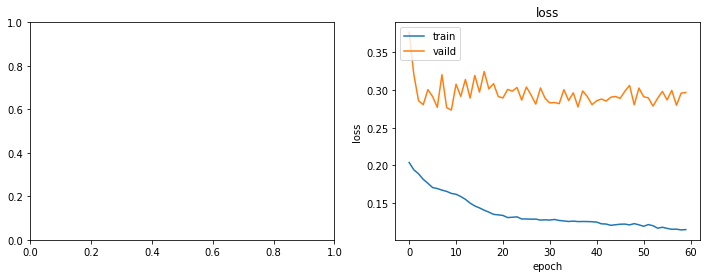

In [55]:
from matplotlib import pyplot as plt
log = pd.read_csv(F'{path}/logs/{model_name}.csv')
print('epochs: ',len(log))
plt.figure(figsize=(12, 4))

# Summarize history for accuracy
plt.subplot(1, 2, 1)
# plt.plot(log['categorical_accuracy'])
# plt.plot(log['val_categorical_accuracy'])
# plt.title('accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'vaild'], loc='upper left') 

# Summarize history for loss 
plt.subplot(1, 2, 2)
plt.plot(log['loss']) 
plt.plot(log['val_loss']) 
plt.title('loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'vaild'], loc='upper left') 

# Save image
plt.savefig(F'{path}/logs/{model_name}.jpg')

In [46]:
# # Pred
train_df['probability'] = model.predict(train_x)
valid_df['probability'] = model.predict(valid_x)
public_df['probability'] = model.predict(public_x)

In [47]:
train_recall_n = recall_n(train_df['sar_flag'].tolist(), train_df['probability'].tolist())
print('train recall_n: ', round(train_recall_n, 5))

train recall_n:  0.67678


In [48]:
valid_recall_n = recall_n(valid_df['sar_flag'].tolist(), valid_df['probability'].tolist())
print('valid recall_n: ', round(valid_recall_n, 5))

valid recall_n:  0.33456


In [49]:
rmse(valid_df['sar_flag'].tolist(), valid_df['probability'].tolist())

0.5229344792785936

## Submission

In [50]:
submission = pd.read_csv(os.path.join(path, 'submission/example.csv'))[['alert_key']]
submission = pd.merge(submission, public_df[['alert_key', 'probability']], on='alert_key', how='left')
submission.describe()

,alert_key,probability
count,3850.000000,1845.000000
mean,365303.605195,0.528604
std,7309.639174,0.245331
min,352249.000000,-0.308099
25%,358829.250000,0.443796
50%,365574.000000,0.620494
75%,371367.500000,0.626660
max,378428.000000,1.042247


In [51]:
submission['probability'] = submission['probability'].fillna(0)
submission['probability'] = submission['probability'].astype('float')
submission['probability'] = submission['probability'].apply(lambda x: 0 if x < 0 else x)

In [52]:
submission.describe()

,alert_key,probability
count,3850.000000,3850.000000
mean,365303.605195,0.253883
std,7309.639174,0.313375
min,352249.000000,0.000000
25%,358829.250000,0.000000
50%,365574.000000,0.000000
75%,371367.500000,0.620112
max,378428.000000,1.042247


In [53]:
submission.to_csv(os.path.join(path, f'submission/lstm.csv'), index=False)